<a href="https://colab.research.google.com/github/AndreaCenturelli/Soft-Robot/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Baselines Tutorial - Multiprocessing of environments

Github repo: https://github.com/araffin/rl-tutorial-jnrr19

Stable-Baselines: https://github.com/hill-a/stable-baselines

Documentation: https://stable-baselines.readthedocs.io/en/master/

RL Baselines zoo: https://github.com/araffin/rl-baselines-zoo


## Introduction

In this notebook, you will learn how to use *Vectorized Environments* (aka multiprocessing) to make training faster. You will also see that this speed up comes at a cost of sample efficiency.

## Install Dependencies and Stable Baselines Using Pip

In [22]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip install stable-baselines[mpi]==2.10.0

TensorFlow is already loaded. Please restart the runtime to change versions.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
libopenmpi-dev is already the newest version (2.1.1-8).
swig is already the newest version (3.0.12-1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


### Remove tensorflow warnings

To have a clean output, we will filter tensorflow warnings, mostly due to the migration from tf 1.x to 2.x

In [1]:
# Filter tensorflow version warnings
import os
# https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import warnings
# https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import tensorflow as tf
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
import logging
tf.get_logger().setLevel(logging.ERROR)

## Vectorized Environments and Imports

[Vectorized Environments](https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html) are a method for stacking multiple independent environments into a single environment. Instead of training an RL agent on 1 environment per step, it allows us to train it on n environments per step. This provides two benefits:
* Agent experience can be collected more quickly
* The experience will contain a more diverse range of states, it usually improves exploration

Stable-Baselines provides two types of Vectorized Environment:
- SubprocVecEnv which run each environment in a separate process
- DummyVecEnv which run all environment on the same process

In practice, DummyVecEnv is usually faster than SubprocVecEnv because of communication delays that subprocesses have.

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym

from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines.common import set_global_seeds
from stable_baselines import PPO2

Import evaluate function

In [3]:
from stable_baselines.common.evaluation import evaluate_policy

## Define an environment function

The multiprocessing implementation requires a function that can be called inside the process to instantiate a gym env

In [4]:
def make_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.
    
    :param env_id: (str) the environment ID
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        env = gym.make(env_id)
        # Important: use a different seed for each environment
        env.seed(seed + rank)
        return env
    set_global_seeds(seed)
    return _init

Stable-Baselines also provides directly an helper to create vectorized environment:

In [5]:
from stable_baselines.common.cmd_util import make_vec_env

## Define a few constants (feel free to try out other environments and algorithms)
We will be using the Cartpole environment: [https://gym.openai.com/envs/CartPole-v1/](https://gym.openai.com/envs/CartPole-v1/)

![Cartpole](https://cdn-images-1.medium.com/max/1143/1*h4WTQNVIsvMXJTCpXm_TAw.gif)



In [6]:
!git clone https://github.com/AndreaCenturelli/Soft-Robot.git
import sys
sys.path.append('/content/Soft-Robot')

Cloning into 'Soft-Robot'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 23 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), done.


In [7]:
import soft_robot_env

In [8]:
!git clone https://github.com/AndreaCenturelli/elastica.git
sys.path.append('/content/elastica')

Cloning into 'elastica'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 60 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (60/60), done.


ModuleNotFoundError: ignored

In [9]:
env_id='soft_robot-v0'
env_id2='CartPole-v1'
env_id3='MountainCar-v0'
env_id4='Acrobot-v1'
# The different number of processes that will be used
PROCESSES_TO_TEST = [1,4] 
NUM_EXPERIMENTS = 3 # RL algorithms can often be unstable, so we run several experiments (see https://arxiv.org/abs/1709.06560)
TRAIN_STEPS = 100
# We will create one environment to evaluate the agent on
eval_env = gym.make(env_id)

## Testing subproc



In [13]:
train_env = SubprocVecEnv([make_env(env_id, i) for i in range(4)], start_method='fork')


In [26]:
reward_averages = []
reward_std = []
training_times = []
total_procs = 0
    
# Here we use the "spawn" method for launching the processes, more information is available in the doc
# This is equivalent to make_vec_env(env_id, n_envs=n_procs, vec_env_cls=SubprocVecEnv, vec_env_kwargs=dict(start_method='spawn'))
train_env = SubprocVecEnv([make_env(env_id, i+total_procs) for i in range(n_procs)], start_method='fork')
print("using subproc")

train_env.reset()
model = PPO2('MlpPolicy', train_env, verbose=0)
start = time.time()
model.learn(total_timesteps=1000)
times.append(time.time() - start)
print('done in:  ',time.time()-start)
train_env.close()

using subproc

 Step number: 
 Step number: 
 Step number: 
 Step number:  1 

 1 
 1 

 1 




100%|██████████| 401/401 [00:00<00:00, 490.72it/s]



 The distance is: 

100%|██████████| 401/401 [00:00<00:00, 457.36it/s]

 0.865887023733093 



 The distance is: 


 87%|████████▋ | 347/401 [00:00<00:00, 399.93it/s]

 0.8660441929025828 



100%|██████████| 401/401 [00:00<00:00, 426.63it/s]



 The distance is: 
 The distance is:  0.8658285744609415 
 0.8659264082454466 



 Step number: 
 Step number: 
 Step number: 
 Step number:  2 
 2 


 2 

 2 



100%|██████████| 401/401 [00:00<00:00, 469.83it/s]



 The distance is: 

100%|██████████| 401/401 [00:00<00:00, 453.62it/s]

 0.8658277822599504 




 82%|████████▏ | 327/401 [00:00<00:00, 337.35it/s]


 The distance is:  0.8659888067285196 


 79%|███████▉  | 317/401 [00:00<00:00, 354.70it/s]

100%|██████████| 401/401 [00:00<00:00, 423.44it/s]



 The distance is:  0.8651922153157457 



100%|██████████| 401/401 [00:00<00:00, 410.85it/s]



 The distance is:  0.8659940533603427 


 Step number: 
 Step number: 
 Step number:  3 

 Step number: 
 3 
 3 
 3 




  0%|          | 0/401 [00:00<?, ?it/s]

100%|██████████| 401/401 [00:00<00:00, 494.27it/s]



 The distance is: 

 74%|███████▍  | 298/401 [00:00<00:00, 360.41it/s]

 0.8658775021634263 


 98%|█████████▊| 391/401 [00:00<00:00, 418.56it/s]

 88%|████████▊ | 353/401 [00:00<00:00, 400.39it/s]


 The distance is:  0.8662779739781352 



100%|██████████| 401/401 [00:00<00:00, 431.75it/s]



 The distance is:  0.8648709297791023 



100%|██████████| 401/401 [00:01<00:00, 396.99it/s]



 The distance is:  0.8663825671545015 


 Step number: 
 Step number: 
 Step number: 
 Step number:  4 

 4 


  0%|          | 0/401 [00:00<?, ?it/s]


 4 
 4 




100%|██████████| 401/401 [00:00<00:00, 494.20it/s]



 The distance is: 

 98%|█████████▊| 394/401 [00:00<00:00, 431.95it/s]

 0.8659811315934923 



 87%|████████▋ | 347/401 [00:00<00:00, 401.42it/s]


 The distance is: 

 86%|████████▌ | 345/401 [00:00<00:00, 403.43it/s]

 0.8647720773799958 



100%|██████████| 401/401 [00:01<00:00, 387.14it/s]



 The distance is: 
 The distance is:  0.8667516990549409 
 0.8665373842146896 



 Step number:  5 

 Step number: 
 Step number: 


  0%|          | 0/401 [00:00<?, ?it/s]


 Step number:  5 
 5 


 5 



100%|██████████| 401/401 [00:00<00:00, 474.20it/s]



 The distance is: 

 94%|█████████▎| 375/401 [00:00<00:00, 416.44it/s]

 0.8647896548057205 



100%|██████████| 401/401 [00:01<00:00, 392.62it/s]



 The distance is: 

100%|██████████| 401/401 [00:00<00:00, 406.00it/s]

 0.8674902636833675 




 The distance is:  0.8668143957094919 



100%|██████████| 401/401 [00:01<00:00, 381.43it/s]



 The distance is:  0.8662557248882582 


 Step number: 
 Step number: 
 Step number:  6 
 6 
 6 




 Step number:  6 



100%|██████████| 401/401 [00:00<00:00, 463.69it/s]



 The distance is: 

 91%|█████████ | 364/401 [00:00<00:00, 440.47it/s]

 0.8644937272205524 



100%|██████████| 401/401 [00:00<00:00, 432.13it/s]



 The distance is: 

100%|██████████| 401/401 [00:00<00:00, 431.70it/s]

 0.8679016599975067 




 The distance is:  0.8663046510507176 



100%|██████████| 401/401 [00:01<00:00, 398.33it/s]



 The distance is:  0.8666916399122361 


 Step number: 
 Step number: 
 Step number: 
 Step number:  7 
 7 
 7 
 7 






100%|██████████| 401/401 [00:00<00:00, 457.61it/s]



 The distance is:  0.866288898550578 



100%|██████████| 401/401 [00:00<00:00, 411.47it/s]


 The distance is:  0.8642122966400624 




 The distance is: 

 91%|█████████ | 365/401 [00:00<00:00, 401.28it/s]

 0.8687261594950209 



100%|██████████| 401/401 [00:01<00:00, 395.37it/s]



 The distance is:  0.8659271317228975 


 Step number: 
 Step number: 
 Step number: 
 8 


  0%|          | 0/401 [00:00<?, ?it/s]


 Step number:  8 
 8 
 8 





100%|██████████| 401/401 [00:00<00:00, 554.95it/s]



 The distance is:  0.869722112576693 



100%|██████████| 401/401 [00:00<00:00, 405.39it/s]



 The distance is: 

100%|██████████| 401/401 [00:01<00:00, 438.40it/s]

 0.8639812830622777 


100%|██████████| 401/401 [00:01<00:00, 374.55it/s]


 The distance is: 

 98%|█████████▊| 394/401 [00:01<00:00, 435.70it/s]


 0.8659576033424565 


100%|██████████| 401/401 [00:01<00:00, 376.52it/s]



 The distance is:  0.8659458998290678 


 Step number: 
 Step number: 
 Step number: 
 Step number:  9 
 9 

 9 
 9 





100%|██████████| 401/401 [00:00<00:00, 522.61it/s]



 The distance is: 

 82%|████████▏ | 328/401 [00:00<00:00, 367.16it/s]

 0.8644354961517995 


 77%|███████▋  | 310/401 [00:00<00:00, 320.37it/s]

100%|██████████| 401/401 [00:00<00:00, 412.00it/s]



 The distance is: 

 96%|█████████▌| 383/401 [00:00<00:00, 403.20it/s]

 0.8701271192243212 



100%|██████████| 401/401 [00:01<00:00, 397.21it/s]



 The distance is:  0.8661840845663002 



100%|██████████| 401/401 [00:01<00:00, 376.26it/s]



 The distance is:  0.8657867073056815 


 Step number: 
 Step number:  10 



  0%|          | 0/401 [00:00<?, ?it/s]


 Step number:  10 

 Step number:  10 

 10 




100%|██████████| 401/401 [00:00<00:00, 506.27it/s]



 The distance is: 

 92%|█████████▏| 370/401 [00:00<00:00, 426.41it/s]

 0.8663558285035194 



100%|██████████| 401/401 [00:00<00:00, 424.49it/s]



 The distance is: 

100%|██████████| 401/401 [00:00<00:00, 427.40it/s]



 The distance is:  0.8709277754706043 

 0.8644353702458324 



100%|██████████| 401/401 [00:00<00:00, 431.86it/s]



 The distance is:  0.8655872074769545 


 Step number: 
 Step number: 
 Step number:  11 
 11 

 Step number:  11 
 11 






 78%|███████▊  | 312/401 [00:00<00:00, 336.42it/s]


 The distance is: 

 97%|█████████▋| 388/401 [00:00<00:00, 457.94it/s]

 0.8661945433844366 



 86%|████████▌ | 344/401 [00:00<00:00, 366.40it/s]


 The distance is:  0.8648403389570067 



100%|██████████| 401/401 [00:00<00:00, 401.20it/s]



 The distance is:  0.8637803553157098 



100%|██████████| 401/401 [00:01<00:00, 392.21it/s]



 The distance is:  0.871889170113949 


 Step number: 
 Step number:  12 

 Step number:  12 

 Step number: 
 12 


 12 


  0%|          | 0/401 [00:00<?, ?it/s]

100%|██████████| 401/401 [00:00<00:00, 539.73it/s]



 The distance is:  0.8636898872412592 



100%|██████████| 401/401 [00:00<00:00, 431.80it/s]



 The distance is: 

 91%|█████████ | 364/401 [00:00<00:00, 416.34it/s]

 0.8647825603814858 



100%|██████████| 401/401 [00:00<00:00, 408.49it/s]



 The distance is:  0.8730211623572959 


100%|██████████| 401/401 [00:00<00:00, 407.05it/s]


 The distance is:  0.8659900821384454 


 Step number: 
 Step number: 
 Step number: 
 Step number:  13 
 13 


 13 


  0%|          | 0/401 [00:00<?, ?it/s]


 13 



100%|██████████| 401/401 [00:00<00:00, 459.23it/s]



 The distance is: 

 82%|████████▏ | 328/401 [00:00<00:00, 412.26it/s]

 0.8649141750748969 


 91%|█████████ | 364/401 [00:00<00:00, 438.78it/s]

100%|██████████| 401/401 [00:00<00:00, 419.45it/s]



 The distance is:  0.874022900234136 



100%|██████████| 401/401 [00:01<00:00, 388.19it/s]



 The distance is: 

 93%|█████████▎| 371/401 [00:01<00:00, 390.85it/s]

 0.8654897199024661 



100%|██████████| 401/401 [00:01<00:00, 375.84it/s]



 The distance is:  0.8640702634238254 


 Step number: 
 Step number:  14 

 Step number: 
 Step number:  14 


 14 
 14 



  0%|          | 0/401 [00:00<?, ?it/s]

 88%|████████▊ | 354/401 [00:00<00:00, 408.14it/s]


 The distance is:  0.8651310128400199 



100%|██████████| 401/401 [00:00<00:00, 430.63it/s]



 The distance is:  0.8643389581466477 


100%|██████████| 401/401 [00:01<00:00, 397.19it/s]




 The distance is:  0.8743052629555536 



100%|██████████| 401/401 [00:00<00:00, 418.40it/s]



 The distance is:  0.8638573716302648 


 Step number:  15 

 Step number:  15 

 Step number: 

 15 


 Step number:  15 



 85%|████████▍ | 339/401 [00:00<00:00, 385.96it/s]


 The distance is:  0.8637869881877234 



100%|██████████| 401/401 [00:00<00:00, 421.22it/s]



 The distance is: 

 94%|█████████▍| 378/401 [00:00<00:00, 435.55it/s]

 0.8645486947710078 



100%|██████████| 401/401 [00:01<00:00, 392.86it/s]


 The distance is: 

 0.8747393306743473 

 The distance is: 
 0.8636371247403181 


 Step number: 
 Step number: 
 Step number:  16 

 16 

 Step number:  16 
 16 


  0%|          | 0/401 [00:00<?, ?it/s]

100%|██████████| 401/401 [00:00<00:00, 463.08it/s]



 The distance is: 

 95%|█████████▍| 380/401 [00:00<00:00, 371.18it/s]

 0.8758945009670266 



100%|██████████| 401/401 [00:01<00:00, 399.16it/s]



 The distance is:  0.8639008445439623 


 The distance is: 

100%|██████████| 401/401 [00:01<00:00, 399.31it/s]

 0.8641796849272771 




 The distance is:  0.8637073012344837 


 Step number: 
 Step number: 
 Step number: 
 Step number:  17 
 17 

 17 
 17 





100%|██████████| 401/401 [00:00<00:00, 487.00it/s]



 The distance is:  0.8636933264504677 



100%|██████████| 401/401 [00:00<00:00, 433.69it/s]



 The distance is:  0.8770236490598811 


 91%|█████████▏| 366/401 [00:00<00:00, 411.83it/s]

100%|██████████| 401/401 [00:00<00:00, 407.10it/s]



 The distance is:  0.8634628640587597 



100%|██████████| 401/401 [00:00<00:00, 403.30it/s]



 The distance is:  0.8638423542240224 


 Step number: 
 Step number:  18 


 Step number: 
 Step number:  18 
 18 

 18 



  0%|          | 0/401 [00:00<?, ?it/s]

100%|██████████| 401/401 [00:00<00:00, 506.70it/s]



 The distance is: 

 87%|████████▋ | 348/401 [00:00<00:00, 431.45it/s]

 0.8773466007032852 



100%|██████████| 401/401 [00:00<00:00, 420.00it/s]



 The distance is:  0.862819979476684 



100%|██████████| 401/401 [00:00<00:00, 409.78it/s]



 The distance is:  0.8635542951719062 



100%|██████████| 401/401 [00:01<00:00, 395.62it/s]



 The distance is:  0.8636341557658004 


 Step number: 
 Step number: 
 Step number: 
 Step number:  19 
 19 
 19 


 19 


  0%|          | 0/401 [00:00<?, ?it/s]

100%|██████████| 401/401 [00:00<00:00, 493.29it/s]



 The distance is: 

 95%|█████████▍| 379/401 [00:00<00:00, 381.39it/s]

 0.862351855517987 


 91%|█████████ | 365/401 [00:00<00:00, 369.28it/s]

100%|██████████| 401/401 [00:01<00:00, 395.71it/s]



 The distance is: 

100%|██████████| 401/401 [00:01<00:00, 398.29it/s]


 0.8629455397471572 



100%|██████████| 401/401 [00:01<00:00, 397.87it/s]


 The distance is: 

 0.8784671256691357 


 The distance is:  0.8631285785976488 


 Step number: 
 Step number: 
 Step number:  20 

 Step number:  20 
 20 


 20 



  0%|          | 0/401 [00:00<?, ?it/s]

100%|██████████| 401/401 [00:00<00:00, 457.29it/s]



 The distance is: 

 97%|█████████▋| 389/401 [00:00<00:00, 414.85it/s]

 0.8625725564512525 


 98%|█████████▊| 391/401 [00:00<00:00, 404.91it/s]

100%|██████████| 401/401 [00:00<00:00, 409.78it/s]



 The distance is: 

100%|██████████| 401/401 [00:00<00:00, 410.78it/s]


 0.8798031744082493 


100%|██████████| 401/401 [00:00<00:00, 424.00it/s]



 The distance is:  0.8623588498158743 



 The distance is:  0.8628362443199399 


 Step number: 
 Step number:  21 

 Step number:  21 

 Step number: 



  0%|          | 0/401 [00:00<?, ?it/s]

 21 
 21 




 85%|████████▌ | 342/401 [00:00<00:00, 393.66it/s]


 The distance is: 

 97%|█████████▋| 387/401 [00:00<00:00, 408.92it/s]

 0.8807677321519777 



 96%|█████████▋| 386/401 [00:00<00:00, 401.76it/s]


 The distance is: 

100%|██████████| 401/401 [00:00<00:00, 406.19it/s]

 0.8626173713966111 




 The distance is:  0.862503889451 



100%|██████████| 401/401 [00:00<00:00, 411.31it/s]



 The distance is:  0.863112118168724 


 Step number: 
 Step number: 
 Step number: 
 Step number:  22 
 22 
 22 



  0%|          | 0/401 [00:00<?, ?it/s]


 22 




100%|██████████| 401/401 [00:00<00:00, 588.07it/s]



 The distance is: 

 64%|██████▍   | 258/401 [00:00<00:00, 350.63it/s]

 0.8811482961628307 



100%|██████████| 401/401 [00:00<00:00, 435.21it/s]



 The distance is:  0.8616665400817961 



100%|██████████| 401/401 [00:00<00:00, 423.31it/s]


 The distance is: 


 The distance is:  0.8632457643038649 

 0.8627549762082926 


 Step number:  23 


 Step number: 
 Step number:  23 


  0%|          | 0/401 [00:00<?, ?it/s]


 Step number:  23 


 23 



 74%|███████▍  | 298/401 [00:00<00:00, 358.55it/s]


 The distance is: 

 83%|████████▎ | 331/401 [00:00<00:00, 389.89it/s]

 0.881516685972315 



100%|██████████| 401/401 [00:00<00:00, 458.29it/s]



 The distance is:  0.8618897453048018 



100%|██████████| 401/401 [00:01<00:00, 393.04it/s]



 The distance is: 

100%|██████████| 401/401 [00:00<00:00, 413.19it/s]

 0.8625990824703704 




 The distance is:  0.8608420798188289 


 Step number: 
 Step number: 
 Step number:  24 

 Step number:  24 
 24 
 24 






 69%|██████▉   | 277/401 [00:00<00:00, 384.36it/s]


 The distance is:  0.8822087126032047 


 95%|█████████▌| 382/401 [00:00<00:00, 456.21it/s]

100%|██████████| 401/401 [00:00<00:00, 474.46it/s]



 The distance is:  0.8623519979424497 



100%|██████████| 401/401 [00:00<00:00, 418.32it/s]



 The distance is: 
 The distance is:  0.8607074318401272 
 0.8616765350808199 



 Step number: 
 Step number: 
 Step number: 
 Step number:  25 
 25 

 25 
 25 




  0%|          | 0/401 [00:00<?, ?it/s]

100%|██████████| 401/401 [00:00<00:00, 425.95it/s]



 The distance is: 

 98%|█████████▊| 393/401 [00:00<00:00, 436.04it/s]

 0.8618331078562312 



 85%|████████▌ | 341/401 [00:00<00:00, 329.06it/s]


 The distance is:  0.882399915392344 


 98%|█████████▊| 394/401 [00:00<00:00, 384.11it/s]

100%|██████████| 401/401 [00:00<00:00, 409.97it/s]



 The distance is:  0.8603446532956294 



100%|██████████| 401/401 [00:01<00:00, 379.95it/s]



 The distance is:  0.8629345863005411 


 Step number: 
 Step number:  26 

 Step number:  26 
 26 

 Step number: 

 26 


  0%|          | 0/401 [00:00<?, ?it/s]

 78%|███████▊  | 314/401 [00:00<00:00, 349.10it/s]


 The distance is: 

 87%|████████▋ | 348/401 [00:00<00:00, 386.28it/s]

 0.881968950966277 



 98%|█████████▊| 392/401 [00:00<00:00, 400.81it/s]


 The distance is: 

 88%|████████▊ | 352/401 [00:00<00:00, 357.41it/s]

 0.8597094355147124 


100%|██████████| 401/401 [00:00<00:00, 416.07it/s]


 The distance is:  0.8626537701634351 



100%|██████████| 401/401 [00:01<00:00, 400.14it/s]



 The distance is:  0.8617346893379986 


 Step number: 
 Step number:  27 

 Step number:  27 


 Step number: 

  0%|          | 0/401 [00:00<?, ?it/s]

 27 
 27 





100%|██████████| 401/401 [00:00<00:00, 443.75it/s]



 The distance is: 

100%|██████████| 401/401 [00:00<00:00, 413.92it/s]

 0.8590752141825939 




 85%|████████▌ | 342/401 [00:00<00:00, 348.17it/s]


 The distance is:  0.8814840142258251 


 99%|█████████▊| 395/401 [00:00<00:00, 421.19it/s]

100%|██████████| 401/401 [00:00<00:00, 419.66it/s]



 The distance is:  0.8622178104321037 



100%|██████████| 401/401 [00:01<00:00, 396.12it/s]



 The distance is:  0.8610337601205917 


 Step number: 
 Step number:  28 



  0%|          | 0/401 [00:00<?, ?it/s]


 Step number: 
 Step number:  28 
 28 
 28 





100%|██████████| 401/401 [00:00<00:00, 559.89it/s]



 The distance is:  0.8817565923389923 



100%|██████████| 401/401 [00:00<00:00, 467.93it/s]



 The distance is:  0.8609538624628881 



100%|██████████| 401/401 [00:00<00:00, 441.36it/s]



 The distance is: 

100%|██████████| 401/401 [00:00<00:00, 408.79it/s]


 0.8620159298351103 

 The distance is:  0.8593345135285946 



 Step number: 
 Step number: 
 Step number: 
 Step number:  29 
 29 
 29 
 29 






100%|██████████| 401/401 [00:00<00:00, 416.85it/s]



 The distance is: 

 94%|█████████▍| 378/401 [00:00<00:00, 446.53it/s]

 0.8596385720156113 


100%|██████████| 401/401 [00:01<00:00, 395.54it/s]


 The distance is: 


 0.8615835956688138 

 The distance is: 
 0.8619372005769714 


100%|██████████| 401/401 [00:00<00:00, 402.35it/s]



 The distance is: 
 0.8816605187346398 


 Step number: 
 Step number: 
 Step number: 
 Step number:  30 
 30 


 30 
 30 




100%|██████████| 401/401 [00:00<00:00, 433.33it/s]



 The distance is: 

 97%|█████████▋| 388/401 [00:00<00:00, 373.31it/s]

 0.8611912453416886 


100%|██████████| 401/401 [00:00<00:00, 420.03it/s]


 The distance is: 


 The distance is:  0.8805341812185049 

 0.8613845523034781 



100%|██████████| 401/401 [00:01<00:00, 393.08it/s]


 The distance is:  0.8594515444408553 


 Step number: 
 Step number: 
 Step number:  31 
 31 

 Step number: 
 31 


 31 


  0%|          | 0/401 [00:00<?, ?it/s]

100%|██████████| 401/401 [00:00<00:00, 453.04it/s]



 The distance is: 

100%|██████████| 401/401 [00:00<00:00, 451.46it/s]

 0.86092410227838 



 88%|████████▊ | 354/401 [00:00<00:00, 409.93it/s]


 The distance is: 
 0.8604970921321253 



 86%|████████▋ | 346/401 [00:00<00:00, 356.94it/s]


 The distance is:  0.8599393535847044 



100%|██████████| 401/401 [00:00<00:00, 401.95it/s]



 The distance is:  0.8802843661966125 


 Step number: 
 Step number: 
 Step number: 
 Step number:  32 



  0%|          | 0/401 [00:00<?, ?it/s]

 32 
 32 
 32 





100%|██████████| 401/401 [00:00<00:00, 483.79it/s]



 The distance is:  0.859909920538915 



100%|██████████| 401/401 [00:00<00:00, 439.67it/s]



 The distance is:  0.8608207477810774 


 94%|█████████▍| 377/401 [00:00<00:00, 397.04it/s]

100%|██████████| 401/401 [00:00<00:00, 402.56it/s]



 The distance is: 

100%|██████████| 401/401 [00:00<00:00, 414.00it/s]



 The distance is:  0.8605284609017696 
 0.880395942255751 



 Step number: 
 Step number: 
 Step number:  33 


 Step number:  33 
 33 
 33 



  0%|          | 0/401 [00:00<?, ?it/s]

100%|██████████| 401/401 [00:00<00:00, 577.10it/s]



 The distance is: 

 73%|███████▎  | 293/401 [00:00<00:00, 406.69it/s]

 0.8609207572149883 



100%|██████████| 401/401 [00:00<00:00, 432.91it/s]



 The distance is: 

100%|██████████| 401/401 [00:00<00:00, 451.70it/s]

 0.8591283276336193 




 The distance is:  0.8801712181440252 



100%|██████████| 401/401 [00:00<00:00, 418.25it/s]



 The distance is:  0.8605235347993048 


 Step number: 
 Step number:  34 

 Step number:  34 

 Step number: 
 34 
 34 



  0%|          | 0/401 [00:00<?, ?it/s]

 83%|████████▎ | 332/401 [00:00<00:00, 387.74it/s]


 The distance is: 

 98%|█████████▊| 393/401 [00:00<00:00, 434.62it/s]

 0.8605285618664671 


100%|██████████| 401/401 [00:00<00:00, 425.56it/s]


 The distance is: 

 94%|█████████▍| 378/401 [00:00<00:00, 400.20it/s]

 0.858144762969334 



100%|██████████| 401/401 [00:00<00:00, 407.10it/s]



 The distance is:  0.8793387909407022 


100%|██████████| 401/401 [00:00<00:00, 404.51it/s]


 The distance is:  0.860094033525081 


 Step number: 
 Step number:  35 
 35 

 Step number: 

 Step number:  35 


  0%|          | 0/401 [00:00<?, ?it/s]


 35 




100%|██████████| 401/401 [00:00<00:00, 629.35it/s]



 The distance is: 

 66%|██████▋   | 266/401 [00:00<00:00, 353.67it/s]

 0.8595290787199028 



100%|██████████| 401/401 [00:00<00:00, 437.31it/s]



 The distance is:  0.8611978931704306 



100%|██████████| 401/401 [00:00<00:00, 406.00it/s]


 The distance is: 

 0.8573390373551877 


 The distance is:  0.8787836395820287 


 Step number: 
 Step number:  36 
 36 



  0%|          | 0/401 [00:00<?, ?it/s]


 Step number: 
 Step number: 
 36 
 36 




100%|██████████| 401/401 [00:00<00:00, 495.23it/s]



 The distance is:  0.8792194128233323 



100%|██████████| 401/401 [00:01<00:00, 398.85it/s]



 The distance is:  0.8569124356433399 



100%|██████████| 401/401 [00:00<00:00, 406.25it/s]


 The distance is: 

 0.8619961025481688 

 The distance is:  0.8597694316432639 



 Step number: 
 Step number:  37 

 Step number: 

 Step number:  37 
 37 



  0%|          | 0/401 [00:00<?, ?it/s]


 37 



100%|██████████| 401/401 [00:00<00:00, 427.34it/s]



 The distance is: 

100%|██████████| 401/401 [00:01<00:00, 396.12it/s]


 The distance is:  0.8792591398975027 



 0.8565890822473111 


100%|██████████| 401/401 [00:01<00:00, 393.56it/s]


 The distance is:  0.8616311094009232 





 The distance is:  0.8599662840364161 


 Step number: 
 Step number:  38 

 Step number: 
 Step number:  38 


 38 
 38 



  0%|          | 0/401 [00:00<?, ?it/s]

100%|██████████| 401/401 [00:00<00:00, 473.99it/s]



 The distance is:  0.8792693918384545 



100%|██████████| 401/401 [00:00<00:00, 417.50it/s]



 The distance is: 

100%|██████████| 401/401 [00:01<00:00, 383.17it/s]


 0.8601181629239026 


100%|██████████| 401/401 [00:01<00:00, 381.66it/s]


 The distance is: 

 0.85604086483109 



 The distance is:  0.8611925318146489 


 Step number: 
 Step number: 
 Step number: 
 Step number:  39 
 39 
 39 
 39 






100%|██████████| 401/401 [00:00<00:00, 459.22it/s]



 The distance is:  0.8554269566500275 


 87%|████████▋ | 348/401 [00:00<00:00, 405.65it/s]

100%|██████████| 401/401 [00:01<00:00, 398.14it/s]



 The distance is:  0.8793089776507784 



100%|██████████| 401/401 [00:01<00:00, 387.34it/s]


 The distance is: 

 0.8613980358919258 

 The distance is:  0.8599424641373474 



 Step number: 
 Step number: 
 Step number: 
 Step number:  40 
 40 
 40 
 40 






100%|██████████| 401/401 [00:00<00:00, 656.52it/s]



 The distance is:  0.8550335847503671 



100%|██████████| 401/401 [00:00<00:00, 464.86it/s]



 The distance is: 

 79%|███████▉  | 318/401 [00:00<00:00, 402.98it/s]

 0.8797317330219453 



100%|██████████| 401/401 [00:00<00:00, 418.42it/s]



 The distance is:  0.861919870029153 



100%|██████████| 401/401 [00:00<00:00, 410.29it/s]



 The distance is:  0.8602072285940043 


 Step number: 
 Step number:  41 

 Step number: 
 41 

 Step number: 
 41 
 41 


  0%|          | 0/401 [00:00<?, ?it/s]

100%|██████████| 401/401 [00:00<00:00, 562.47it/s]



 The distance is:  0.8550240314532831 


 75%|███████▌  | 302/401 [00:00<00:00, 419.56it/s]

100%|██████████| 401/401 [00:00<00:00, 458.20it/s]



 The distance is: 

100%|██████████| 401/401 [00:00<00:00, 437.25it/s]

 0.8611459000897225 



 The distance is:  0.8800468397381324 




100%|██████████| 401/401 [00:00<00:00, 424.39it/s]



 The distance is:  0.8623284581411088 


 Step number: 
 Step number: 
 Step number:  42 
 42 


 Step number: 


  0%|          | 0/401 [00:00<?, ?it/s]

 42 


  0%|          | 0/401 [00:00<?, ?it/s]

 42 




 78%|███████▊  | 311/401 [00:00<00:00, 372.45it/s]


 The distance is:  0.8792894843630228 


 79%|███████▉  | 317/401 [00:00<00:00, 399.37it/s]

100%|██████████| 401/401 [00:00<00:00, 406.72it/s]



 The distance is: 

100%|██████████| 401/401 [00:01<00:00, 386.47it/s]

 0.8619336079309019 




100%|██████████| 401/401 [00:00<00:00, 405.40it/s]



 The distance is:  0.8624253244692403 


 The distance is:  0.8554073946685975 


 Step number: 
 Step number: 
 Step number:  43 

 43 

 Step number: 

  0%|          | 0/401 [00:00<?, ?it/s]

 43 

 43 




100%|██████████| 401/401 [00:00<00:00, 432.92it/s]



 The distance is:  0.8788419030221807 



 97%|█████████▋| 389/401 [00:00<00:00, 400.53it/s]


 The distance is: 

 89%|████████▉ | 358/401 [00:00<00:00, 377.74it/s]

 0.8555900586873748 


100%|██████████| 401/401 [00:00<00:00, 404.22it/s]


 The distance is: 

100%|██████████| 401/401 [00:01<00:00, 399.96it/s]

 0.8632260856702484 




 The distance is:  0.8621533889008819 


 Step number: 
 Step number:  44 

 Step number: 
 Step number: 
 44 

 44 
 44 




 83%|████████▎ | 333/401 [00:00<00:00, 348.70it/s]


 The distance is:  0.8559188793211575 


100%|██████████| 401/401 [00:00<00:00, 413.27it/s]




 The distance is:  0.8792553067534518 



100%|██████████| 401/401 [00:01<00:00, 385.59it/s]



 The distance is: 

100%|██████████| 401/401 [00:01<00:00, 366.98it/s]

 0.8641113719509289 



 The distance is:  0.8625875669808152 



 Step number: 
 Step number: 
 Step number:  45 

 Step number:  45 
 45 


 45 



  0%|          | 0/401 [00:00<?, ?it/s]

100%|██████████| 401/401 [00:00<00:00, 458.74it/s]



 The distance is:  0.8791657885524872 



100%|██████████| 401/401 [00:00<00:00, 421.17it/s]



 The distance is: 

100%|██████████| 401/401 [00:00<00:00, 405.13it/s]

 0.8650015558033081 




 The distance is: 

100%|█████████▉| 399/401 [00:01<00:00, 427.44it/s]

 0.864005075999762 



100%|██████████| 401/401 [00:01<00:00, 385.53it/s]



 The distance is:  0.8563559935547737 


 Step number: 
 Step number:  46 


 Step number:  46 

 Step number:  46 




  0%|          | 0/401 [00:00<?, ?it/s]

 46 



 75%|███████▍  | 300/401 [00:00<00:00, 378.92it/s]


 The distance is:  0.8569476164385866 


 97%|█████████▋| 389/401 [00:00<00:00, 393.10it/s]

100%|██████████| 401/401 [00:00<00:00, 413.57it/s]



 The distance is: 

 88%|████████▊ | 352/401 [00:00<00:00, 412.39it/s]

 0.8780166933039284 


100%|██████████| 401/401 [00:00<00:00, 402.62it/s]



 The distance is:  0.8652556319743312 




100%|██████████| 401/401 [00:01<00:00, 399.12it/s]



 The distance is:  0.8648615644728666 


 Step number: 
 Step number: 
 Step number:  47 



  0%|          | 0/401 [00:00<?, ?it/s]


 Step number:  47 
 47 
 47 





100%|██████████| 401/401 [00:00<00:00, 457.27it/s]



 The distance is: 

 95%|█████████▌| 382/401 [00:00<00:00, 439.65it/s]

 0.8658086335275316 


 86%|████████▋ | 346/401 [00:00<00:00, 401.74it/s]

 90%|████████▉ | 359/401 [00:00<00:00, 383.81it/s]


 The distance is:  0.8658579655923057 


100%|██████████| 401/401 [00:01<00:00, 395.32it/s]


 The distance is:  0.8769320817944792 



100%|██████████| 401/401 [00:01<00:00, 399.54it/s]



 The distance is:  0.8569724264507153 


 Step number: 
 Step number:  48 
 48 



 Step number: 
 Step number:  48 

 48 


  0%|          | 0/401 [00:00<?, ?it/s]

 96%|█████████▌| 384/401 [00:00<00:00, 408.16it/s]


 The distance is:  0.8566864743688121 



100%|██████████| 401/401 [00:00<00:00, 414.58it/s]


 The distance is:  0.8670139498359154 




Process ForkProcess-41:
Process ForkProcess-44:
Process ForkProcess-42:
Process ForkProcess-43:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/stable_baselines/common/vec_env/subproc_vec_env.py", line 18, in _worker
    observation, reward, do

KeyboardInterrupt: ignored

In [28]:
train_env.close()


## Iterate through the different numbers of processes

For each processes, several experiments are run per process
This may take a couple of minutes.

In [29]:
reward_averages = []
reward_std = []
training_times = []
total_procs = 0
for n_procs in PROCESSES_TO_TEST:
    total_procs += n_procs
    print('Running for n_procs = {}'.format(n_procs))
    if n_procs == 1:
        # if there is only one process, there is no need to use multiprocessing
        train_env = DummyVecEnv([lambda: gym.make(env_id)])
        print("using dummy")
    else:
        # Here we use the "spawn" method for launching the processes, more information is available in the doc
        # This is equivalent to make_vec_env(env_id, n_envs=n_procs, vec_env_cls=SubprocVecEnv, vec_env_kwargs=dict(start_method='spawn'))
        train_env = SubprocVecEnv([make_env(env_id, i+total_procs) for i in range(n_procs)], start_method='fork')
        print("using subproc")
    rewards = []
    times = []
    train_env.reset()
    model = PPO2('MlpPolicy', train_env, verbose=0)
    start = time.time()
    model.learn(total_timesteps=1000)
    times.append(time.time() - start)
    print('here')
    train_env.close()
    training_times.append(np.mean(times))

Running for n_procs = 1
using dummy

 Step number:  1 



KeyboardInterrupt: ignored

## Plot the results

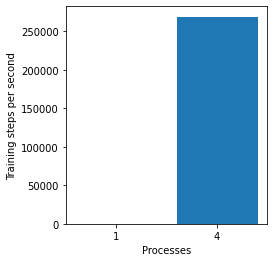

In [24]:
training_steps_per_second = [TRAIN_STEPS / t for t in training_times]

plt.figure(figsize=(9, 4))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 2)
plt.bar(range(len(PROCESSES_TO_TEST)), training_steps_per_second)
plt.xticks(range(len(PROCESSES_TO_TEST)), PROCESSES_TO_TEST)
plt.xlabel('Processes')
_ = plt.ylabel('Training steps per second')

## Sample efficiency vs wall clock time trade-off
There is clearly a trade-off between sample efficiency, diverse experience and wall clock time. Lets try getting the best performance in a fixed amount of time, say 10 seconds per experiment

In [ ]:
SECONDS_PER_EXPERIMENT = 10
steps_per_experiment = [int(SECONDS_PER_EXPERIMENT * fps) for fps in training_steps_per_second]
reward_averages = []
reward_std = []
training_times = []

for n_procs, train_steps in zip(PROCESSES_TO_TEST, steps_per_experiment):
    total_procs += n_procs
    print('Running for n_procs = {} for steps = {}'.format(n_procs, train_steps))
    if n_procs == 1:
        # if there is only one process, there is no need to use multiprocessing
        train_env = DummyVecEnv([lambda: gym.make(env_id)])
    else:
        train_env = SubprocVecEnv([make_env(env_id, i+total_procs) for i in range(n_procs)], start_method='spawn')
        # Alternatively, you can use a DummyVecEnv if the communication delays is the bottleneck
        # train_env = DummyVecEnv([make_env(env_id, i+total_procs) for i in range(n_procs)])

    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # it is recommended to run several experiments due to variability in results
        train_env.reset()
        model = ALGO('MlpPolicy', train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=train_steps)
        times.append(time.time() - start)
        mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)

    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))


## Plot the results

Text(0, 0.5, 'Training steps per second')

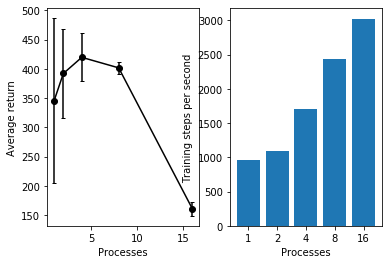

In [ ]:
training_steps_per_second = [s / t for s,t in zip(steps_per_experiment, training_times)]

plt.figure()
plt.subplot(1,2,1)
plt.errorbar(PROCESSES_TO_TEST, reward_averages, yerr=reward_std, capsize=2, c='k', marker='o')
plt.xlabel('Processes')
plt.ylabel('Average return')
plt.subplot(1,2,2)
plt.bar(range(len(PROCESSES_TO_TEST)), training_steps_per_second)
plt.xticks(range(len(PROCESSES_TO_TEST)),PROCESSES_TO_TEST)
plt.xlabel('Processes')
plt.ylabel('Training steps per second')

## DummyVecEnv vs SubprocVecEnv

In [ ]:
reward_averages = []
reward_std = []
training_times = []
total_procs = 0
for n_procs in PROCESSES_TO_TEST:
    total_procs += n_procs
    print('Running for n_procs = {}'.format(n_procs))
    # Here we are using only one process even for n_env > 1
    # this is equivalent to DummyVecEnv([make_env(env_id, i + total_procs) for i in range(n_procs)])
    train_env = make_vec_env(env_id, n_envs=n_procs)

    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # it is recommended to run several experiments due to variability in results
        train_env.reset()
        model = ALGO('MlpPolicy', train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=TRAIN_STEPS)
        times.append(time.time() - start)
        mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)

    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))

Text(0, 0.5, 'Training steps per second')

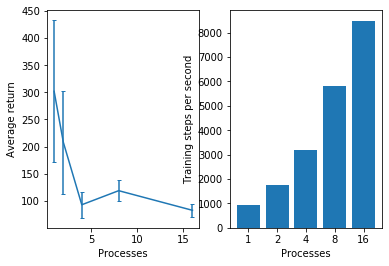

In [ ]:
training_steps_per_second = [TRAIN_STEPS / t for t in training_times]

plt.figure()
plt.subplot(1,2,1)
plt.errorbar(PROCESSES_TO_TEST, reward_averages, yerr=reward_std, capsize=2)
plt.xlabel('Processes')
plt.ylabel('Average return')
plt.subplot(1,2,2)
plt.bar(range(len(PROCESSES_TO_TEST)), training_steps_per_second)
plt.xticks(range(len(PROCESSES_TO_TEST)),PROCESSES_TO_TEST)
plt.xlabel('Processes')
plt.ylabel('Training steps per second')

### What's happening?

It seems that having only one process for n environments is faster in our case.
In practice, the bottleneck does not come from the environment computation, but from synchronisation and communication between processes. To learn more about that problem, you can start [here](https://github.com/hill-a/stable-baselines/issues/322#issuecomment-492202915)

## Conclusions
This notebook has highlighted some of the pros and cons of multiprocessing. It is worth mentioning that colab notebooks only provide two CPU cores per process, so we do not see a linear scaling of the FPS of the environments. State of the art Deep RL research has scaled parallel processing to tens of thousands of CPU cores, [OpenAI RAPID](https://openai.com/blog/how-to-train-your-openai-five/) [IMPALA](https://arxiv.org/abs/1802.01561).

Do you think this direction of research is transferable to real world robots / intelligent agents?

Things to try:
* Another algorithm / environment.
* Increase the number of experiments.
* Train for more iterations.
